In [1]:
import pathpy as pp
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import networkx as nx
import folium
import time
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
from MOGen_path_prediction import MOGenPathPrediction
import prediction_model_evaluation_metrics as metrics

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# Load a model from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_date = '202205'
test_date = '202206'
DP_tol = 10
min_samples = 13

model_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [3]:
# Load training data from file
filename = model_name+'_'+train_date+'_paths.csv'
training_data = pd.read_csv('../../data/paths/'+filename)
training_data['path'] = training_data['path'].apply(literal_eval)
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.GeoSeries.from_wkt(training_data['geometry']), crs=network.crs)
training_data = training_data[training_data['message']=='success']
# extract paths from the training data
training_paths = training_data['path'].tolist()
training_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1433 entries, 0 to 1451
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Unnamed: 0        1433 non-null   int64   
 1   mmsi              1433 non-null   object  
 2   SSPD              1433 non-null   float64 
 3   distances         1433 non-null   object  
 4   fraction_covered  1433 non-null   float64 
 5   message           1433 non-null   object  
 6   path              1433 non-null   object  
 7   path_linestring   1433 non-null   object  
 8   lengde            1433 non-null   int64   
 9   bredde            1039 non-null   float64 
 10  dypgaaende        942 non-null    float64 
 11  skipstype         1039 non-null   object  
 12  skipsgruppe       1039 non-null   object  
 13  geometry          1433 non-null   geometry
dtypes: float64(4), geometry(1), int64(2), object(7)
memory usage: 167.9+ KB


In [4]:
# Load test data from file
filename = model_name+'_'+test_date+'_paths.csv'
test_data = pd.read_csv('../../data/paths/'+filename)
test_data['path'] = test_data['path'].apply(literal_eval)
test_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs=network.crs)
test_data = test_data[test_data['message']=='success']

In [5]:
# Load respective trajectories for evaluation
traj_file = test_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + traj_file + '.parquet'
traj_gdf = gpd.read_parquet(filename)
crs = network.crs  # Coordinate reference system
traj_gdf.to_crs(crs, inplace=True)  # Transformation
test_trajectories = mpd.TrajectoryCollection(traj_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

In [6]:
# Train MOGen Model
mogen = MOGenPathPrediction()
mogen.train(training_paths, max_order=3, model_selection=True)

order:  3; log_L (8 prcs): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]

Selected optimal maximum order K=1 from candidates.
MOGen model
- Model Selection ------------------------------------
 K  |   nodes     edges   |   log L    dof         AIC
 1  |    676      37557   | -17802.81  1822   39249.63
 2  |   1812      37557   | -14290.97  6141   40863.95
 3  |   3394      37557   | -12477.11 20666   66286.23


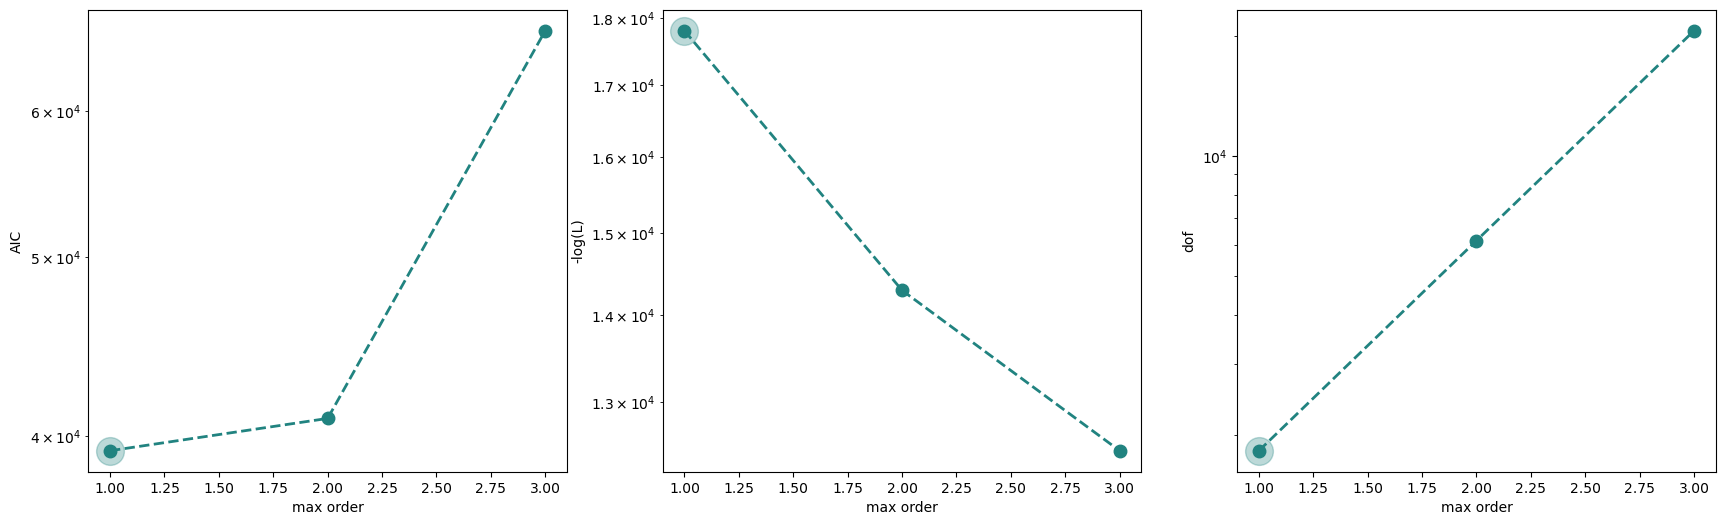

In [7]:
mogen.model.plot()

Evaluating MOGen model on 3 samples for path prediction task
Progress: 10%...20%...30%...Done!


Time elapsed: 0.19 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 95.02m
Median SSPD: 109.79m
Mean choice_accuracy: 0.7445


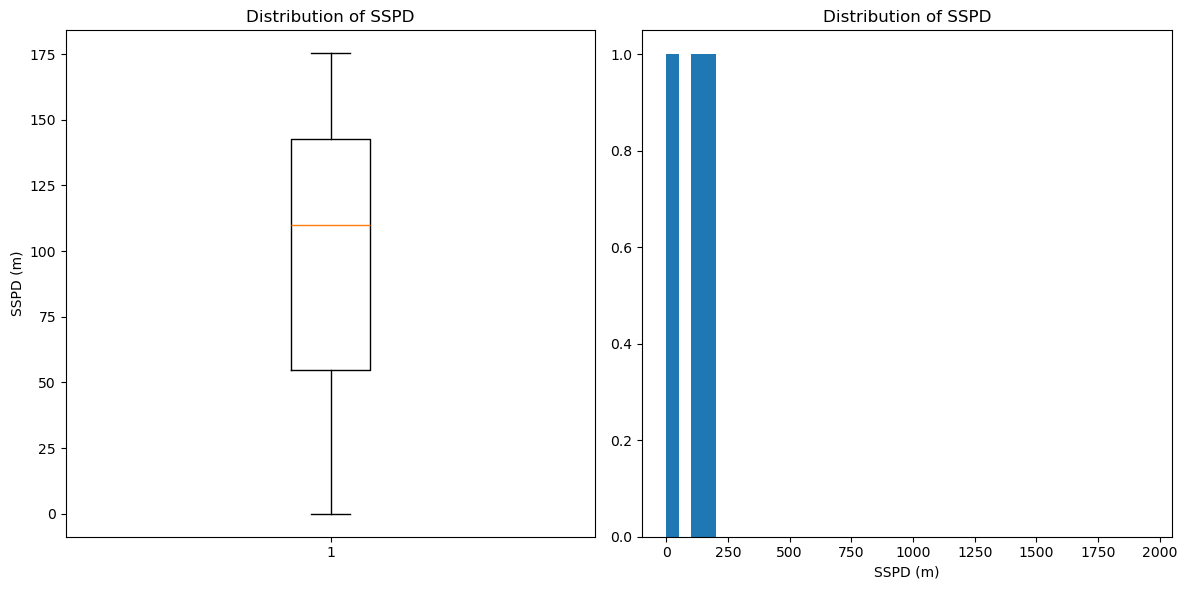

In [10]:
selection = range(0, 6, 2)  # len(test_data)
test_paths = test_data.iloc[selection]
eval_results, fig = metrics.evaluate(mogen, 'path', test_paths, test_trajectories, network, MOGen_n_walks=500, eval_mode='path')

In [11]:
nan_mask =eval_results.isna().any(axis=1)
eval_results[nan_mask]

,mmsi,true_path,predicted_path,distances,SSPD,choice_accuracy


In [33]:
# make predictions with the MOGen model
prediction_task = 'start_to_end'
example = test_data.iloc[1]
mmsi = example.mmsi
start_node = [example.path[0]]
end_node = example.path[-1]
print(start_node)
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

if prediction_task == 'next_nodes':
    predictions = mogen.predict_next_nodes(start_node=start_node, G=network.G, n_predictions=5, n_steps=6, n_walks=200)
if prediction_task == 'start_to_end':
    predictions, flag = mogen.predict_path(start_node, end_node, network.G, n_predictions=5, n_walks=2000, verbose=True)

[505]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.99s/it]


In [35]:
map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+model_name+'_MOGen_predictions.html')
print(f'Map saved under {"../../reports/maps/"+model_name+"_MOGen_predictions.html"}')

Map saved under ../../reports/maps/202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM_MOGen_predictions.html
